In [1]:
%load_ext autoreload
%autoreload 2

# Test smina (and AmberTools)

Some code is deactivated.<br/>
Now smina is run through by a function

### Needs rdkit>=2020.03.3

In [2]:
import rdkit
assert '2020.03.3' <= rdkit.__version__

In [3]:
from rdkit import Chem
from rdkit.Chem.rdMolAlign import GetBestRMS
from cbiprep.pdbatoms import PDBAtoms
from cbiprep.ligand_expo import LigandExpo
from cbiprep.jupyter_utils import draw_mol
import pandas as pd
import subprocess as sp
import os, re, time

In [4]:
def check_dir(pdb_code, workdir='work'):
    print(sp.check_output(f'ls -l {workdir}/{pdb_code}', shell=True, universal_newlines=True))

In [5]:
lig_expo = LigandExpo()

In [6]:
df = pd.read_pickle('index_2019.pkl.gz')

### tleap (protein structure prep)

### Docking by SMINA

### SMINA docking as a function

Inputs:
- pdb_code
- ligand_name
- workdir = 'work'
- ncpu = os.cpu_count()
- num_modes = 4
- seed = 0

In [7]:
def smina(pdb_code, ligand_name, workdir='work', ncpu=0, num_modes=4, seed=0):
    def run_tleap_to_create_receptor_mol2():
        tleaprc_template = os.path.abspath(os.path.dirname(Chem.__file__) + '/../../../../../cbiprep/data/tleaprc.template')
        logFile = f'{workdir}/{pdb_code}/{pdb_code}_tleap.log'
        test = f'{workdir}/{pdb_code}/{pdb_code}_relevant.pdb'
        saveMol2 = f'{workdir}/{pdb_code}/{pdb_code}_relevant.mol2'
        tleaprc = f'{workdir}/{pdb_code}/{pdb_code}_tleaprc'
        cont = open(tleaprc_template, 'rt').read()
        cont = cont.replace('{{logFile}}', logFile).replace('{{test}}', test).replace('{{saveMol2}}', saveMol2)
        open(tleaprc, 'wt').write(cont)

        command = f'tleap -s -f {tleaprc} > /dev/null 2>&1'
        print(command)
        sp.call(command, shell=True)
        return saveMol2
    
    def fix_receptor(saveMol2):
        receptor_fixed_mol2 = f'{workdir}/{pdb_code}/{pdb_code}_charged.mol2'
        command = f'obabel {saveMol2} -O {receptor_fixed_mol2} > /dev/null 2>&1'
        print(command)
        sp.call(command, shell=True)
        return receptor_fixed_mol2
        
    def run_smina(fixed_receptor_mol2, ligand_sdf):
        boxpars = sp.check_output(f'ligand_center {ligand_sdf}', shell=True).decode().strip()

        docked_sdf = f'{workdir}/{pdb_code}/{pdb_code}_ligand_{ligand_name}_docked.sdf'
        smina_log = f'{workdir}/{pdb_code}/{pdb_code}_{ligand_name}_smina.log'
        command = f'smina -r {fixed_receptor_mol2} -l {ligand_sdf} {boxpars} --cpu {ncpu} --num_modes {num_modes} --seed {seed} -o {docked_sdf} --log {smina_log}'
        print(command)
        sp.call(command, shell=True)
        return docked_sdf
    if ncpu == 0:
        ncpu = os.cpu_count()
    ligand_sdf = f'{workdir}/{pdb_code}/{pdb_code}_ligand_{ligand_name}.sdf'
    for ligand_mol in Chem.SDMolSupplier(ligand_sdf):
        break
    smi = Chem.MolToSmiles(ligand_mol)
    print(f'{pdb_code} {ligand_name} {smi}')
    draw_mol(Chem.MolFromSmiles(smi))
    pdb_atoms = PDBAtoms(f'pdb/{pdb_code}.pdb.gz')
    lig_atoms = pdb_atoms.get_ligand(ligand_name)
    protein_atoms = pdb_atoms.get_relevant_protein(lig_atoms, thres=4)
    protein_name = f'{workdir}/{pdb_code}/{pdb_code}_relevant.pdb'
    open(protein_name, 'wt').write(str(protein_atoms))
    fixed_receptor_mol2 = fix_receptor(run_tleap_to_create_receptor_mol2())
    docked_sdf = run_smina(fixed_receptor_mol2, ligand_sdf)
    return docked_sdf

In [8]:
DF = df[(df['type'] == 'Kd') & (df['lig_ok'] == True) & (df['refined'] == True)]
DF

,pdb,year,pval,type,lig,lig_ok,refined
122,2r58,2007,2.00,Kd,MLY,True,True
123,3c2f,2008,2.00,Kd,PRP,True,True
130,4qsu,2014,2.00,Kd,TDR,True,True
131,4qsv,2014,2.00,Kd,THM,True,True
147,4u54,2015,2.06,Kd,3C5,True,True
...,...,...,...,...,...,...,...
17585,3k8q,2010,11.28,Kd,22A,True,True
17602,2x00,2010,11.33,Kd,GYN,True,True
17621,4ll3,2014,11.57,Kd,017,True,True
17627,4jn2,2013,11.68,Kd,4CC,True,True


In [9]:
def check_rmsd(pdb_code, ligand_name, docked_sdf, workdir='work'):
    ligand_sdf = f'{workdir}/{pdb_code}/{pdb_code}_ligand_{ligand_name}.sdf'
    for ligand_mol in Chem.SDMolSupplier(ligand_sdf):
        break
    rmsds = []
    for i, mol in enumerate(Chem.SDMolSupplier(docked_sdf), start=1):
        rmsd = GetBestRMS(mol, ligand_mol)
        rmsds.append(round(rmsd, 3))
    return rmsds

<hr/>

### SMINA for all PDBs

In [10]:
DF = df[(df['type'] == 'Kd') & (df['lig_ok'] == True) & (df['refined'] == True)]
DF = DF.sort_values(by='pval', ascending=False)

----------------------------------------------------------------------------------------------------
4ll3 017 CC(C)CN(C[C@@H](O)[C@H](Cc1ccccc1)NC(=O)O[C@H]1CO[C@H]2OCC[C@@H]12)S(=O)(=O)c1ccc(N)cc1


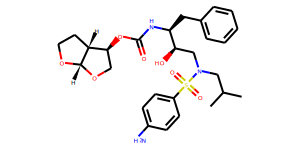

tleap -s -f work/4ll3/4ll3_tleaprc > /dev/null 2>&1
obabel work/4ll3/4ll3_relevant.mol2 -O work/4ll3/4ll3_charged.mol2 > /dev/null 2>&1
smina -r work/4ll3/4ll3_charged.mol2 -l work/4ll3/4ll3_ligand_017.sdf --center_x -9.815 --center_y 15.2 --center_z 26.964 --size_x 18.253 --size_y 17.285 --size_z 25.221 --cpu 10 --num_modes 4 --seed 0 -o work/4ll3/4ll3_ligand_017_docked.sdf --log work/4ll3/4ll3_017_smina.log
1 2.981
2 0.843
3 2.844
4 0.675
Lapse = 41.3s
----------------------------------------------------------------------------------------------------
2x00 GYN CC1=C([C@@H]2C[C@H](C)C(=O)O2)CC[C@]23CCCN=C2CC/C=C(\C)[C@@H]2O[C@@H](CC[C@H](O)/C(C)=C/[C@@H]13)C[C@H]2C


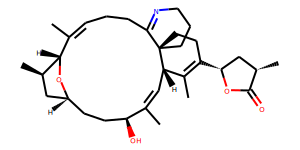

tleap -s -f work/2x00/2x00_tleaprc > /dev/null 2>&1
obabel work/2x00/2x00_relevant.mol2 -O work/2x00/2x00_charged.mol2 > /dev/null 2>&1
smina -r work/2x00/2x00_charged.mol2 -l work/2x00/2x00_ligand_GYN.sdf --center_x 4.086 --center_y 25.72 --center_z -4.616 --size_x 17.821 --size_y 17.151 --size_z 23.401 --cpu 10 --num_modes 4 --seed 0 -o work/2x00/2x00_ligand_GYN_docked.sdf --log work/2x00/2x00_GYN_smina.log
1 0.264
Lapse = 8.9s
----------------------------------------------------------------------------------------------------
3k8q 22A O=c1[nH]cnc2c(CNC(CO)CO)c[nH]c12


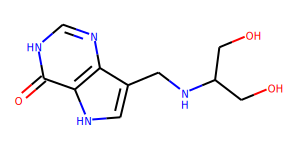

tleap -s -f work/3k8q/3k8q_tleaprc > /dev/null 2>&1
obabel work/3k8q/3k8q_relevant.mol2 -O work/3k8q/3k8q_charged.mol2 > /dev/null 2>&1
smina -r work/3k8q/3k8q_charged.mol2 -l work/3k8q/3k8q_ligand_22A.sdf --center_x 14.551 --center_y 11.146 --center_z 58.112 --size_x 14.358 --size_y 14.366 --size_z 18.184 --cpu 10 --num_modes 4 --seed 0 -o work/3k8q/3k8q_ligand_22A_docked.sdf --log work/3k8q/3k8q_22A_smina.log
1 1.223
2 1.167
3 0.566
4 1.229
Lapse = 5.5s
----------------------------------------------------------------------------------------------------
5h8e 5Y3 CC(=O)Nc1cc(Nc2cc(NC3CC3)n3ncc(C#N)c3n2)ccc1N(C)CCN


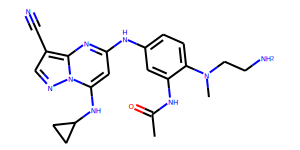

tleap -s -f work/5h8e/5h8e_tleaprc > /dev/null 2>&1
obabel work/5h8e/5h8e_relevant.mol2 -O work/5h8e/5h8e_charged.mol2 > /dev/null 2>&1
smina -r work/5h8e/5h8e_charged.mol2 -l work/5h8e/5h8e_ligand_5Y3.sdf --center_x 18.439 --center_y 66.751 --center_z 34.443 --size_x 19.511 --size_y 20.614 --size_z 18.5 --cpu 10 --num_modes 4 --seed 0 -o work/5h8e/5h8e_ligand_5Y3_docked.sdf --log work/5h8e/5h8e_5Y3_smina.log
1 0.426
2 2.935
3 1.511
4 1.718
Lapse = 20.6s
----------------------------------------------------------------------------------------------------
5llg VD9 CCCS[C@H]1CC[C@H](S(N)(O)O)CC1.CCCSc1ccc(S(N)(=O)=O)cc1


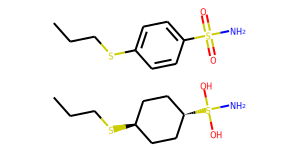

tleap -s -f work/5llg/5llg_tleaprc > /dev/null 2>&1
obabel work/5llg/5llg_relevant.mol2 -O work/5llg/5llg_charged.mol2 > /dev/null 2>&1
smina -r work/5llg/5llg_charged.mol2 -l work/5llg/5llg_ligand_VD9.sdf --center_x 3.929 --center_y 1.049 --center_z 13.341 --size_x 31.957 --size_y 21.113 --size_z 21.712 --cpu 10 --num_modes 4 --seed 0 -o work/5llg/5llg_ligand_VD9_docked.sdf --log work/5llg/5llg_VD9_smina.log
1 0.233
2 0.238
3 1.353
4 1.202
Lapse = 4.7s
----------------------------------------------------------------------------------------------------
3k8o 229 O=c1[nH]cnc2c(CN[C@H](CO)[C@H](O)CO)c[nH]c12


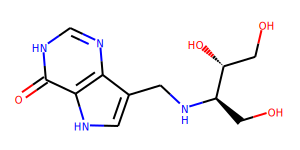

tleap -s -f work/3k8o/3k8o_tleaprc > /dev/null 2>&1
obabel work/3k8o/3k8o_relevant.mol2 -O work/3k8o/3k8o_charged.mol2 > /dev/null 2>&1
smina -r work/3k8o/3k8o_charged.mol2 -l work/3k8o/3k8o_ligand_229.sdf --center_x -43.507 --center_y 0.881 --center_z -2.7 --size_x 14.417 --size_y 18.675 --size_z 15.152 --cpu 10 --num_modes 4 --seed 0 -o work/3k8o/3k8o_ligand_229_docked.sdf --log work/3k8o/3k8o_229_smina.log
1 2.094
2 2.106
3 1.467
4 1.899
Lapse = 7.7s
----------------------------------------------------------------------------------------------------
5bs4 4UX CN[C@H]1CO[C@@H]2OC[C@H](OC(=O)N[C@@H](Cc3ccccc3)[C@H](O)CN(CC(C)C)S(=O)(=O)c3ccc(N)cc3)[C@H]12


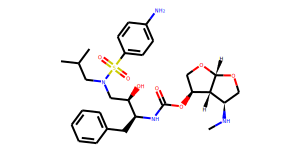

tleap -s -f work/5bs4/5bs4_tleaprc > /dev/null 2>&1
obabel work/5bs4/5bs4_relevant.mol2 -O work/5bs4/5bs4_charged.mol2 > /dev/null 2>&1
smina -r work/5bs4/5bs4_charged.mol2 -l work/5bs4/5bs4_ligand_4UX.sdf --center_x 17.83 --center_y 23.185 --center_z 18.288 --size_x 22.546 --size_y 20.832 --size_z 16.739 --cpu 10 --num_modes 4 --seed 0 -o work/5bs4/5bs4_ligand_4UX_docked.sdf --log work/5bs4/5bs4_4UX_smina.log
1 3.547
2 0.626
3 2.054
4 0.637
Lapse = 50.3s
----------------------------------------------------------------------------------------------------
3lzs 017 CC(C)CN(C[C@@H](O)[C@H](Cc1ccccc1)NC(=O)O[C@H]1CO[C@H]2OCC[C@@H]12)S(=O)(=O)c1ccc(N)cc1


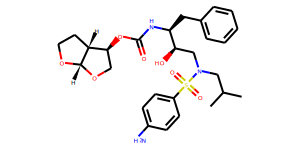

tleap -s -f work/3lzs/3lzs_tleaprc > /dev/null 2>&1
obabel work/3lzs/3lzs_relevant.mol2 -O work/3lzs/3lzs_charged.mol2 > /dev/null 2>&1
smina -r work/3lzs/3lzs_charged.mol2 -l work/3lzs/3lzs_ligand_017.sdf --center_x -9.917 --center_y 15.488 --center_z 0.295 --size_x 18.088 --size_y 17.346 --size_z 24.959 --cpu 10 --num_modes 4 --seed 0 -o work/3lzs/3lzs_ligand_017_docked.sdf --log work/3lzs/3lzs_017_smina.log
1 1.861
2 2.967
3 2.631
4 0.555
Lapse = 38.7s
----------------------------------------------------------------------------------------------------
1m7y PPG Cc1ncc(COP(=O)(O)O)c(CN=C(C=COCCN)C(=O)O)c1O


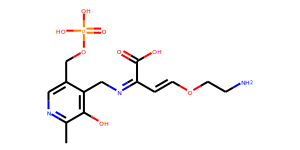

tleap -s -f work/1m7y/1m7y_tleaprc > /dev/null 2>&1
obabel work/1m7y/1m7y_relevant.mol2 -O work/1m7y/1m7y_charged.mol2 > /dev/null 2>&1
smina -r work/1m7y/1m7y_charged.mol2 -l work/1m7y/1m7y_ligand_PPG.sdf --center_x 20.089 --center_y -0.179 --center_z 21.441 --size_x 19.932 --size_y 16.367 --size_z 18.896 --cpu 10 --num_modes 4 --seed 0 -o work/1m7y/1m7y_ligand_PPG_docked.sdf --log work/1m7y/1m7y_PPG_smina.log
1 1.397
2 1.776
3 3.007
4 1.787
Lapse = 20.3s
----------------------------------------------------------------------------------------------------
2pk6 O33 CSC[C@H](NC(=O)COc1cccc2cnccc12)C(=O)N[C@@H](Cc1ccccc1)[C@H](O)C(=O)N1CSC(C)(C)[C@H]1C(=O)N[C@H]1c2ccccc2C[C@H]1O


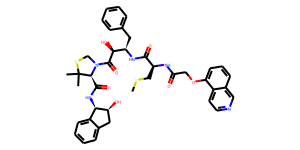

tleap -s -f work/2pk6/2pk6_tleaprc > /dev/null 2>&1
obabel work/2pk6/2pk6_relevant.mol2 -O work/2pk6/2pk6_charged.mol2 > /dev/null 2>&1
smina -r work/2pk6/2pk6_charged.mol2 -l work/2pk6/2pk6_ligand_O33.sdf --center_x 13.711 --center_y -21.279 --center_z -16.214 --size_x 23.464 --size_y 22.02 --size_z 21.08 --cpu 10 --num_modes 4 --seed 0 -o work/2pk6/2pk6_ligand_O33_docked.sdf --log work/2pk6/2pk6_O33_smina.log


In [ ]:
for i in DF.index:
    r = DF.loc[i]
    pdb_code = r['pdb']
    ligand_name = r['lig']
    rmsd_oname = f'work/{pdb_code}/rmsd'
    if os.path.exists(rmsd_oname):
        continue
    print('-'*100)
    start = time.time()
    docked_sdf = smina(pdb_code, ligand_name, ncpu=10)
    with open(rmsd_oname, 'wt') as out:
        for i, rmsd in enumerate(check_rmsd(pdb_code, ligand_name, docked_sdf), start=1):
            print(i, rmsd)
            print(i, rmsd, file=out)
    lapse = time.time() - start
    print(f'Lapse = {lapse:.1f}s')